# Titanic Survival Prediction

### 1. Data Acquisition

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set()
df = pd.read_csv('train.csv')
df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### 2. Data Cleansing

- Missing Age = Age Median

In [3]:
age = df['Age'].median()
df['Age'] = df['Age'].fillna(age)
df['Age'].isnull().sum()  # Check if age is missing (T = Missing, F = Not Missing)

0

- Missing Embarked = Most Embarked

In [4]:
port = df['Embarked'].value_counts().index[0] 
df['Embarked'] = df['Embarked'].fillna (port) 
df['Embarked'].isnull().sum()  # Check if Embarked is missing (T = Missing, F = Not Missing)

0

- Remove Features unrelated to survivorship & Change value to integer

In [5]:
df.drop(['PassengerId', 'Cabin', 'Name', 'Ticket'], axis=1, inplace=True) 
df['Fare'] = df['Fare'].astype(int)
df['Age'] = df['Age'].astype(int)
df.head()

Survived  Pclass     Sex  Age  SibSp  Parch  Fare Embarked
0         0       3    male   22      1      0     7        S
1         1       1  female   38      1      0    71        C
2         1       3  female   26      0      0     7        S
3         1       1  female   35      1      0    53        S
4         0       3    male   35      0      0     8        S

### 3. Feature Engineering for Categorical Data

- DataFrame ==>  List of dictionaries

In [6]:
data = df.to_dict(orient='records')
data[0]

{'Survived': 0,
 'Pclass': 3,
 'Sex': 'male',
 'Age': 22,
 'SibSp': 1,
 'Parch': 0,
 'Fare': 7,
 'Embarked': 'S'}

- Data (Sex, Embarked) == (**one-hot encoding**) ==> Integer

In [7]:
from sklearn.feature_extraction import DictVectorizer 
vec = DictVectorizer(sparse=False, dtype=int)
data_np = vec.fit_transform(data)
data_np[0]

array([22,  0,  0,  1,  7,  0,  3,  0,  1,  1,  0])

In [8]:
print(vec.get_feature_names_out())

['Age' 'Embarked=C' 'Embarked=Q' 'Embarked=S' 'Fare' 'Parch' 'Pclass'
 'Sex=female' 'Sex=male' 'SibSp' 'Survived']


- data_np ==> DataFrame

In [9]:
df = pd.DataFrame(data_np, columns=vec.get_feature_names_out())
df.head()

Age  Embarked=C  Embarked=Q  Embarked=S  Fare  Parch  Pclass  Sex=female  \
0   22           0           0           1     7      0       3           0   
1   38           1           0           0    71      0       1           1   
2   26           0           0           1     7      0       3           1   
3   35           0           0           1    53      0       1           1   
4   35           0           0           1     8      0       3           0   

   Sex=male  SibSp  Survived  
0         1      1         0  
1         0      1         1  
2         0      0         1  
3         0      1         1  
4         1      0         0

### 4. Gaussian NB Classification

- DataFrame  ==>  X =  Feature matrix , Y = Target Array

In [10]:
X = df.drop('Survived', axis=1) 
y = df['Survived']
X.shape, y.shape

((891, 10), (891,))

- Seperate into train & test set

In [11]:
from sklearn.model_selection import train_test_split
X1, X2, y1, y2 = train_test_split(X, y, random_state=1, train_size=0.8) 
X1.shape, y1.shape

((712, 10), (712,))

In [12]:
from sklearn.naive_bayes import GaussianNB 
model = GaussianNB() 
model.fit(X1, y1)

GaussianNB()

Calculate Accuracy Score

In [13]:
from sklearn.metrics import accuracy_score
y2_model = model.predict(X2) 
accuracy_score(y2, y2_model)

0.770949720670391

50:50 cross validation

In [14]:
X1, X2, y1, y2= train_test_split(X, y, random_state=1, train_size=0.5)
y2_model = model.fit(X1, y1).predict(X2) 
y1_model = model.fit(X2, y2).predict(X1)
accuracy_score(y1,y1_model), accuracy_score(y2, y2_model)

(0.8112359550561797, 0.7690582959641256)

### 5. Derived Features
- Adding derived features to icnrese model complexity

In [15]:
X['Age_Cls'] = X['Age'] * X['Pclass']
X['Relatives'] = X['SibSp'] + X['Parch'] 
X.tail()

Age  Embarked=C  Embarked=Q  Embarked=S  Fare  Parch  Pclass  Sex=female  \
886   27           0           0           1    13      0       2           0   
887   19           0           0           1    30      0       1           1   
888   28           0           0           1    23      2       3           1   
889   26           1           0           0    30      0       1           0   
890   32           0           1           0     7      0       3           0   

     Sex=male  SibSp  Age_Cls  Relatives  
886         1      0       54          0  
887         0      0       19          0  
888         0      1       84          3  
889         1      0       26          0  
890         1      0       96          0

In [16]:
X1, X2, y1, y2 = train_test_split(X, y, random_state=1, train_size=0.5)
y2_model = model.fit(X1, y1).predict(X2)
y1_model = model.fit(X2, y2).predict(X1)
accuracy_score(y1, y1_model), accuracy_score(y2, y2_model)

(0.8157303370786517, 0.773542600896861)

### 6. K-Means Clustering

In [17]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
y_model= kmeans.predict(X)

C:\Users\me\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\me\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [18]:
result = y.to_frame()
result['Cluster'] = y_model.tolist()
result.head()

Survived  Cluster
0         0        1
1         1        1
2         1        1
3         1        1
4         0        1

In [19]:
accuracy_score(y,y_model)

0.3557800224466891

### 7. Dimensionality Reduction 

C:\Users\me\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


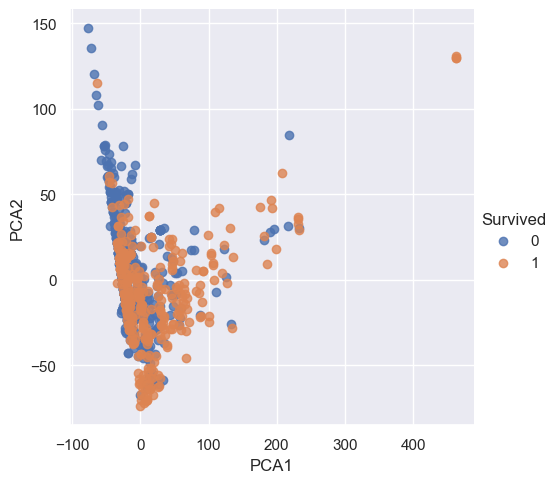

In [20]:
from sklearn.decomposition import PCA
model = PCA(n_components=2)
model.fit(X)
X_2D =  model.transform(X)
df['PCA1'] = X_2D[:, 0]
df['PCA2'] = X_2D[:, 1]
sns.lmplot(x='PCA1', y='PCA2', hue='Survived', data=df, fit_reg=False)